# Capstone project by Sebastien Peytrignet

# Trash or Treasure? Using machine learning to classify and segment images of litter

# Notebook 3: Classification problem C.1 - classifying objects

## 1) Load packages

In [1]:
%matplotlib inline
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## 2) Load data for classification models

In [6]:
# Retrieve directory where we will get the raw data from
parent_directory = os.path.abspath('../')
dataset_path = os.path.join(parent_directory,'data/TACO/data')

# Retrieve directory where we will get save processed data and features
features_path = os.path.join(parent_directory,'data/features')
# os.makedirs(features_path, exist_ok=True)

In the previous steps, we selected 1,561 samples (or annotations) to use in our first classification problem. The class labels for those samples are included in the dataset 'c1_info', which we load again below.

In [7]:
# Load the image labels and information
with np.load("{}/{}".format(features_path,"classification-labels.npz"), allow_pickle=True) as npz_file:
    # It's a dictionary-like object
    print(list(npz_file.keys()))

    # Load the arrays
    c1_info = npz_file["c1"]
    c1_info_colnames = npz_file["c1_colnames"]

c1_info = pd.DataFrame(c1_info, columns=c1_info_colnames)
c1_info

['c1', 's1', 'c1_colnames', 's1_colnames']


id image_id category_id c1_numlabel c1_label annotations_by_image
0        1        0           6         2.0   Bottle                    1
1        2        1          18         3.0   Carton                    2
2        3        1          14         3.0   Carton                    2
3        4        2           5         2.0   Bottle                    1
4        6        3           5         2.0   Bottle                    3
...    ...      ...         ...         ...      ...                  ...
1556  4776     1497           6         2.0   Bottle                    2
1557  4777     1497           6         2.0   Bottle                    2
1558  4779     1498          16         3.0   Carton                    1
1559  4782     1499          14         3.0   Carton                    2
1560  4783     1499           6         2.0   Bottle                    2

[1561 rows x 6 columns]

We also load the procssed images themselves, which are stored in a 4-dimensional numpy array 'c1_images'.

In [10]:
# Load the processed (cropped+framed) images
with np.load("{}/{}/{}".format(features_path,"widen_param_0.05","classification-images.npz"), allow_pickle=True) as npz_file:
    # It's a dictionary-like object
    print(list(npz_file.keys()))

    # Load the arrays
    c1_images = npz_file["c1"]

['c1', 'c2', 's1', 's1_masks']


We can see from the pie chart below that our original sample was unbalanced: the most frequent cateogory, plastic film (29%), has more than twice the number of samples as the least common category, cups (12%).

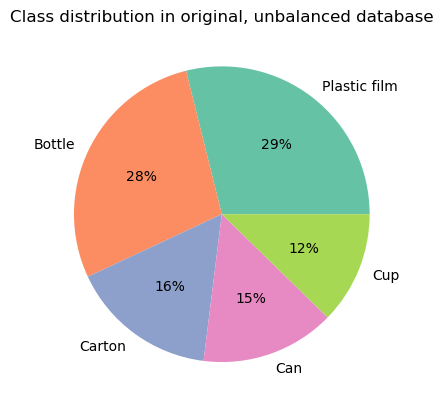

In [11]:
piecolors = sns.color_palette('Set2',5)
plt.pie(c1_info.c1_label.value_counts(normalize=False), labels = c1_info.c1_label.value_counts(normalize=False).index, colors = piecolors, autopct='%.0f%%')
plt.title("Class distribution in original, unbalanced database")
plt.show()

## 3) Extract features

We use a pre-trained model, ResNet50V2, to create features that we will use in our machine learning models. ResNet50V2 is a deep convolutional neural network architecture used for image classification. This model was trained on the ImageNet dataset, which contains over 1 million images from [1,000 different image categories](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/). It has a top-1 accuracy of 76.0% on those classes.

This dataset includes a wide variety of images, such as animals, objects and people. Looking at the 1,000 categories included in ImageNet we can see that ResNet50V2 has already been trained to detect some of our classes, such as cans and bottles.

In [12]:
import tensorflow as tf
import tensorflow_hub as hub

2024-05-04 08:50:26.780919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

First, we check that our images have the required shape of 224x224 pixels, and we rescale the values for each pixel to the 0-1 range.

In [14]:
c1_images.shape

(1561, 224, 224, 3)

In [15]:
c1_data_processed = c1_images*1./255.

In [16]:
feature_extractor_layer = hub.KerasLayer(resnet_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224, 224, 3)) # define the input image shape

2024-05-04 08:50:43.400010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Then, we generate our 2,048 features in batches of 32 images to avoid overwhelming our runtime's memory.

In [17]:
#Generate high-level features in batches

batch_size = 32

for i in range(0, c1_data_processed.shape[0], batch_size):

  batch_c1_features = pd.DataFrame(feature_extractor_layer(c1_data_processed[i:(i+batch_size),:,:,:]).numpy())

  if i==0:
    c1_features = batch_c1_features
  else:
    c1_features = pd.concat([c1_features,batch_c1_features])

Then, we add our class labels (in string and numeric format) into the features dataset.

In [18]:
#Create training dataframe with features from ResNet50V2
c1_features.reset_index(drop=True,inplace=True)
c1_features.columns = c1_features.columns+1
c1_features = c1_features.add_prefix('feat_')

#Add variables
c1_features["annotation_id"] = c1_info["id"].copy()
c1_features["c1_label"] = c1_info["c1_label"].copy()
c1_features["c1_numlabel"] = c1_info["c1_numlabel"].copy()
c1_features = c1_features[c1_features.columns[::-1]]

#Inspect first few rows
c1_features.head(10)

c1_numlabel c1_label annotation_id  feat_2048  feat_2047  feat_2046  \
0         2.0   Bottle             1   0.000000   0.050308   0.489720   
1         3.0   Carton             2   0.016749   0.402603   0.082591   
2         3.0   Carton             3   0.187111   0.730265   0.017274   
3         2.0   Bottle             4   0.052835   0.000000   0.000000   
4         2.0   Bottle             6   0.004975   0.008609   0.077124   
5         2.0   Bottle             7   2.988679   0.241006   0.000000   
6         4.0      Can             9   0.017171   0.242250   0.114890   
7         4.0      Can            10   0.334378   0.069231   2.281562   
8         2.0   Bottle            13   0.169037   0.300295   0.300800   
9         2.0   Bottle            18   0.619309   0.737272   0.533513   

   feat_2045  feat_2044  feat_2043  feat_2042  ...   feat_10    feat_9  \
0   0.000000   0.032107   0.124284   0.000000  ...  2.571053  5.334683   
1   0.000000   0.029750   0.000000   0.000000  ...  0.042408  1.066764   
2   0.000000   0.000000   0.086928   0.000000  ...  0.011163  0.628070   
3   0.000000   0.279649   0.000000   0.000000  ...  0.004448  0.320454   
4   0.000000   0.341330   0.890142   0.000000  ...  0.727989  0.731481   
5   0.286299   0.158813   0.265916   0.000000  ...  0.000000  0.000000   
6   0.000000   0.086534   0.000000   0.003143  ...  0.896433  1.558552   
7   0.000000   0.000000   0.586581   0.004220  ...  0.371993  1.435410   
8   0.000000   0.000000   0.000000   0.000000  ...  0.216905  1.165062   
9   0.000000   0.269416   0.000000   0.000607  ...  0.000000  0.279992   

     feat_8    feat_7    feat_6    feat_5    feat_4    feat_3    feat_2  \
0  0.000000  0.792219  0.000000  0.080972  0.052082  0.000000  0.000000   
1  0.391926  0.005017  0.000000  0.000000  0.000000  0.095207  0.000000   
2  2.314357  0.006719  0.000000  0.000000  0.000000  0.054957  0.000000   
3  0.000000  0.372669  0.000000  0.126056  0.023610  0.000000  0.064648   
4  0.387769  0.143636  0.000000  0.017649  0.011170  0.051558  1.469814   
5  0.055434  0.357544  0.000000  0.078873  0.227037  0.127127  0.314141   
6  0.034449  0.882568  0.000000  0.323684  0.757865  0.049998  0.345090   
7  0.648124  2.793521  0.000000  1.819340  0.000000  0.000000  0.000000   
8  0.000000  0.164491  0.000000  0.498832  0.222087  0.000000  0.000000   
9  0.000000  0.508029  0.005348  0.623931  0.049481  0.000000  0.264277   

     feat_1  
0  0.105036  
1  0.123031  
2  3.062518  
3  0.554045  
4  0.000000  
5  0.037348  
6  0.092474  
7  0.573282  
8  2.758739  
9  0.094424  

[10 rows x 2051 columns]

## 4) Visualize the data

Now, let's visualize the samples included in our classification problem to check that they are labelled properly and have been resized in the way we expected.

We notice that the pictred objects have been subjected to a fair amount of 'wear and tear', with many cans in the wild having been crushed, for example. If ResNet50V2 was trained on a 'cleaner' set of images (e.g. cans on a shelf in a shop) then it might not classify these objects as accurately.

In [19]:
from random import sample

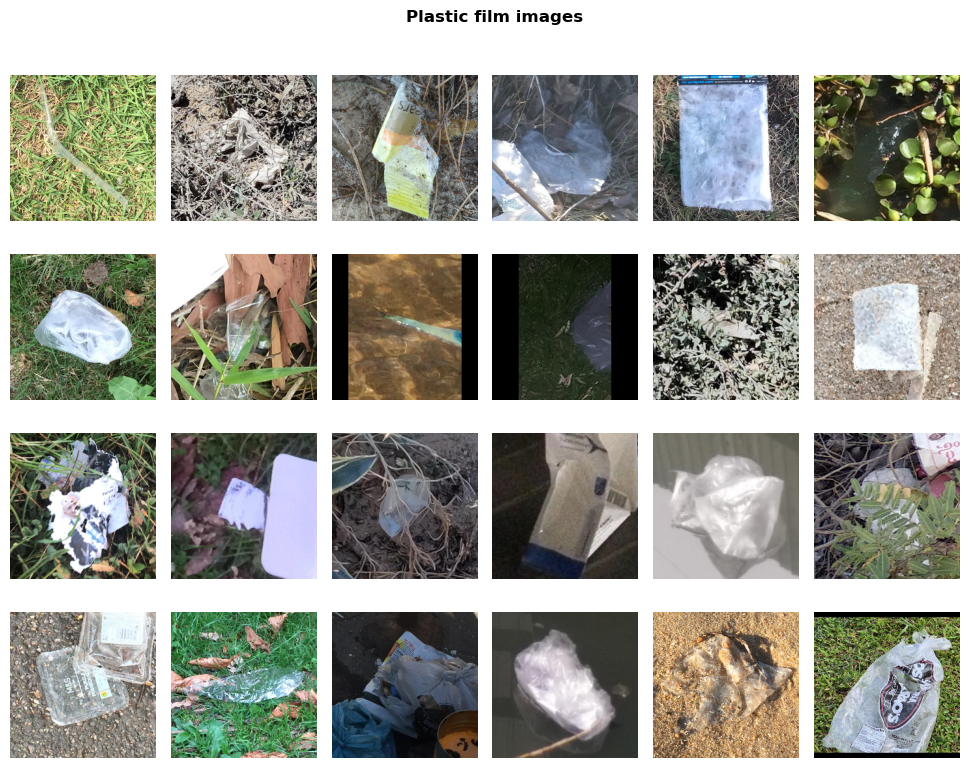

In [20]:
annotations_samples = sample(list(c1_features.index[c1_features.c1_label=="Plastic film"]),24)

fig, axes = plt.subplots(4,6,figsize = (10,8))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(c1_images[annotindex,:,:,:])
  ax.set_axis_off()

fig.suptitle("Plastic film images", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

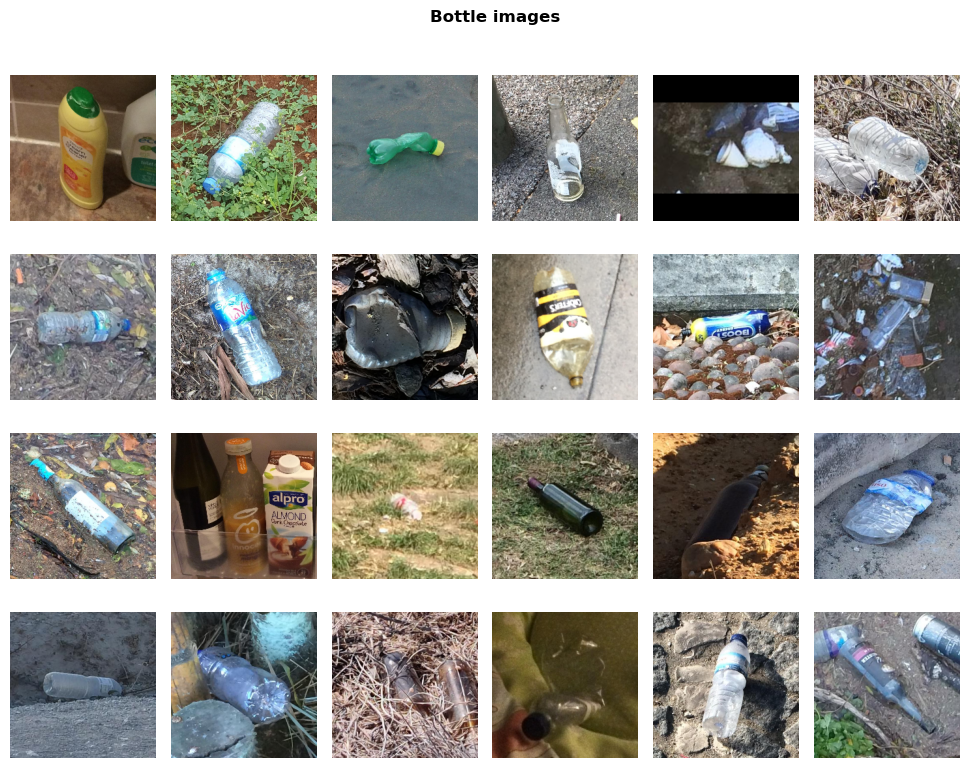

In [21]:
annotations_samples = sample(list(c1_features.index[c1_features.c1_label=="Bottle"]),24)

fig, axes = plt.subplots(4,6,figsize = (10,8))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(c1_images[annotindex,:,:,:])
  ax.set_axis_off()

fig.suptitle("Bottle images", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

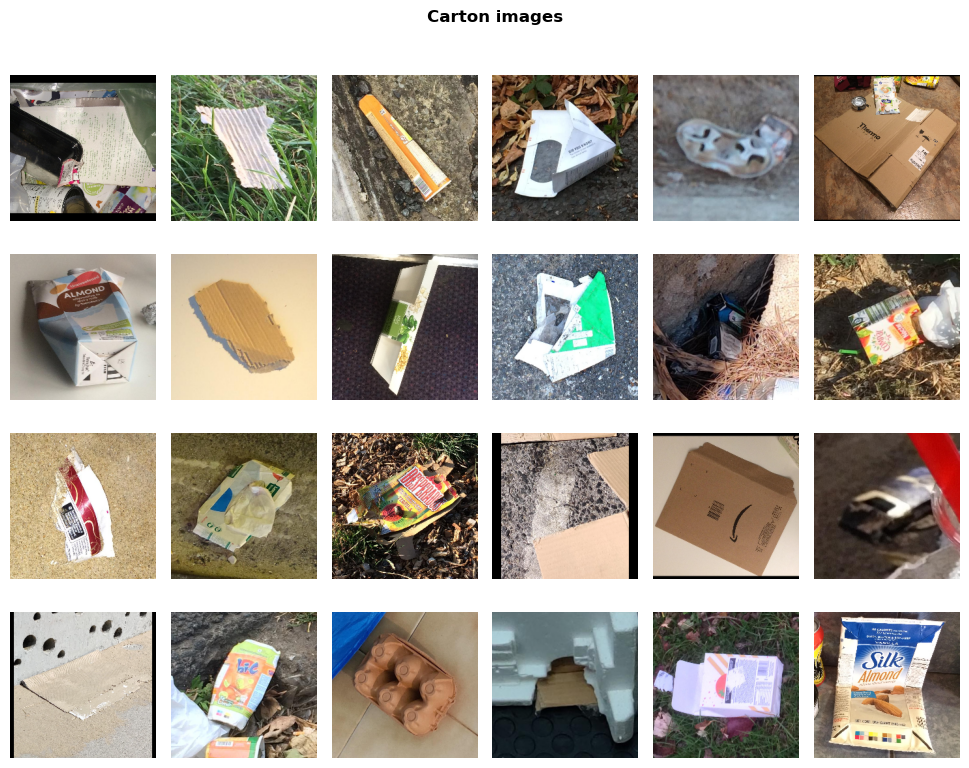

In [22]:
annotations_samples = sample(list(c1_features.index[c1_features.c1_label=="Carton"]),24)

fig, axes = plt.subplots(4,6,figsize = (10,8))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(c1_images[annotindex,:,:,:])
  ax.set_axis_off()

fig.suptitle("Carton images", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

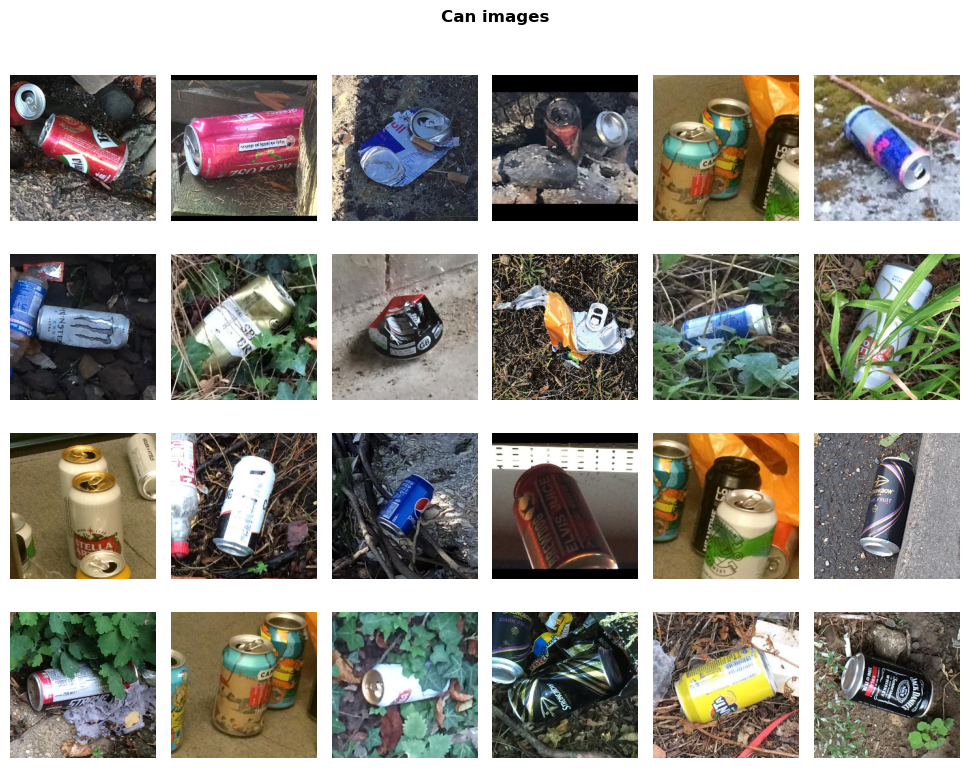

In [23]:
annotations_samples = sample(list(c1_features.index[c1_features.c1_label=="Can"]),24)

fig, axes = plt.subplots(4,6,figsize = (10,8))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(c1_images[annotindex,:,:,:])
  ax.set_axis_off()

fig.suptitle("Can images", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

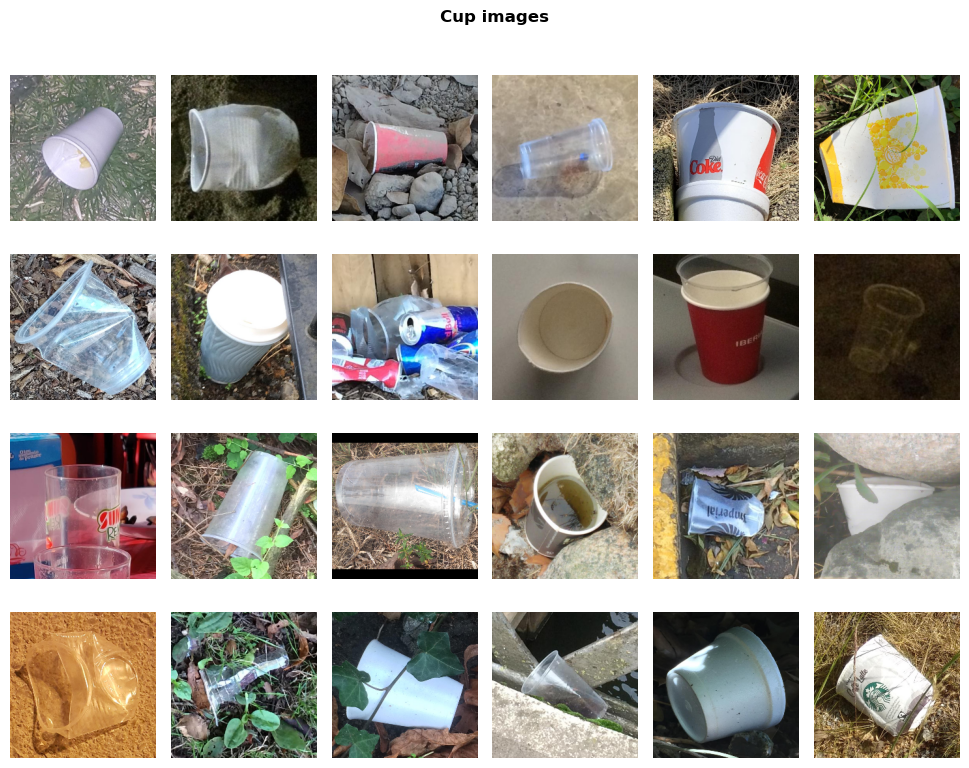

In [24]:
annotations_samples = sample(list(c1_features.index[c1_features.c1_label=="Cup"]),24)

fig, axes = plt.subplots(4,6,figsize = (10,8))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(c1_images[annotindex,:,:,:])
  ax.set_axis_off()

fig.suptitle("Cup images", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

## 5) Create a balanced dataset

As shown in first pie chart above, our original dataset is unbalanced. This could result in the following issues in our classification problem:

* Overfitting to the most frequent class: When the most frequent class class has a significantly larger proportion of data points, the model may become overly focused on recognizing patterns within this class.

* Misleading accuracy: Overall accuracy may appear high even when the model performs poorly on the minority class.

We choose to balance our dataset using random undersampling. Undersampling reduces the number of majority class instances to bring the classes closer to balance. We choose this approach because of its simplicity - it also avoids creating artificial duplicates of our minority class images. A drawback is that we removed usable samples.

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# X = c1_features.drop(["c1_label","c1_numlabel","annotation_id"], axis=1)
# ylab = c1_features["c1_label"]

# random_under_sampler = RandomUnderSampler(random_state=0)

# X_balanced, ylab_balanced = random_under_sampler.fit_resample(X, ylab)

In [ ]:
# X.shape, ylab.shape

In [ ]:
# X_balanced.shape, ylab_balanced.shape

## 6) Split out the testing set

After having balanced our dataset, we split it into a training/validation set (80%) and a testing set (20%). We choose to combine the training and validation set into one, because we will be applying 5-fold cross validation on the combined set later on.

In [25]:
X = c1_features.drop(["c1_label","c1_numlabel","annotation_id"], axis=1)
ylab = c1_features["c1_label"]

In [27]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, ylab_trainval, ylab_test = train_test_split(X, ylab,
                                                    test_size=0.2,
                                                    random_state=8,
                                                    stratify=ylab)

#Pandas dataframe for EDA

c1_trainval = pd.concat([ylab_trainval, X_trainval], axis=1)

#Numpy arrays for ML models

  #X features
X_trainval = X_trainval.values
X_test = X_test.values

  #Y labels
ylab_trainval = ylab_trainval.values
ylab_test = ylab_test.values

print("X_trainval: {}, ylab_trainval: {}".format(X_trainval.shape,ylab_trainval.shape))
print("X_test: {}, ylab_test: {}".format(X_test.shape,ylab_test.shape))

X_trainval: (1248, 2048), ylab_trainval: (1248,)
X_test: (313, 2048), ylab_test: (313,)


We visualize the class distribution of the training/validation and testing sets and we are satisfied that these two samples are now balanced.

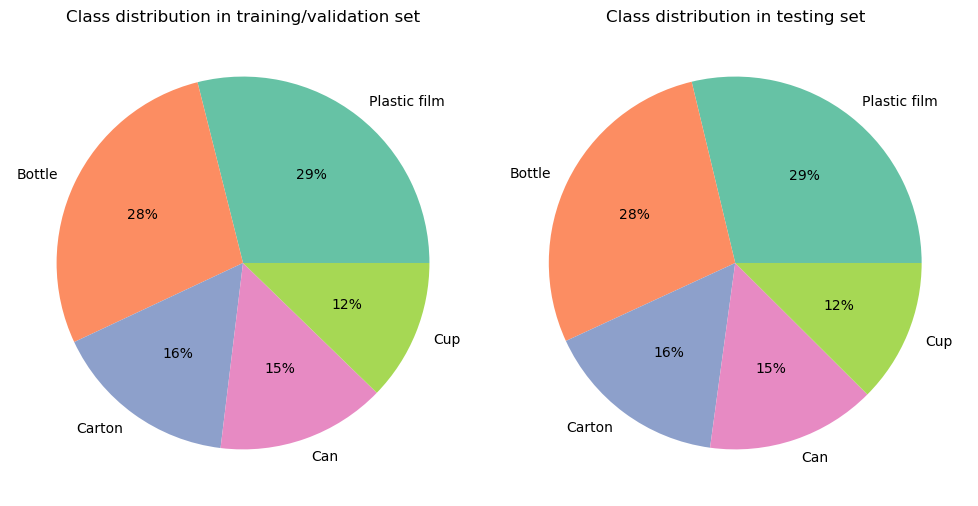

In [28]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True

plt.subplot(1, 2, 1)
plt.pie(pd.Series(ylab_trainval).value_counts(normalize=False), labels = pd.Series(ylab_trainval).value_counts(normalize=False).index, colors = piecolors, autopct='%.0f%%')
plt.title("Class distribution in training/validation set")

plt.subplot(1, 2, 2)
plt.pie(pd.Series(ylab_test).value_counts(normalize=False), labels = pd.Series(ylab_test).value_counts(normalize=False).index, colors = piecolors, autopct='%.0f%%')
plt.title("Class distribution in testing set")

plt.show()

plt.rcParams.update(plt.rcParamsDefault)

## 7) Feature analysis and correlations

Next, we will run some exploratory data analysis on the 2,048 features created by the ResNet50V2 model.

In [ ]:
c1_trainval.head(10)

We can see that there are no missing values in these features.

In [ ]:
feature_column_names = c1_trainval.columns[c1_trainval.columns.str.startswith('feat')]
c1_trainval[feature_column_names] = c1_trainval[feature_column_names].apply(pd.to_numeric)

In [ ]:
(c1_trainval.drop(["c1_label"], axis=1).isna().sum(axis=0)>0).sum() #No missing values in any of the features

Then, we see that the minimum value for all features is zero.

In [ ]:
c1_trainval.describe()

In [ ]:
c1_trainval.describe().loc["min",:].unique() #There are no negative values

The maximum value for the 2,048 features goes up to 30 for some features. Therefore, there is some variation in the range of our features.

In [ ]:
c1_trainval.describe().loc["max",:].hist()
plt.title("Distribution of maximum value in features")
plt.xlabel("Maximum value")
plt.ylabel("Number of features")
plt.show()

The 2,048 features often have a value of zero. In fact, from below, we can see that about 24% of features are majority-zero.

In [ ]:
percent_zero_in_features = (c1_trainval.drop(["c1_label"], axis=1).apply(lambda x: x==0, axis=0).sum(axis=0))/c1_trainval.shape[0]*100
percent_zero_in_features.hist()
plt.title("Distribution of nullness in features ('percent zero')")
plt.xlabel("Percent zero")
plt.ylabel("Number of features")
plt.show()

In [ ]:
(percent_zero_in_features>50).sum()/c1_trainval.shape[1] #About 24% are majority-zero features

The heatmaps below diplay the values of those features for each class. We can see that some features (vertical lines) are more active in some classes compared to others, with consistently higher values across all samples.

In [ ]:
minrange = np.min(c1_trainval.describe().loc["min",:])
maxrange = np.max(c1_trainval.describe().loc["max",:])

In [ ]:
c1_trainval["c1_label"].unique()

In [ ]:
fig, axes = plt.subplots(2,3,figsize = (12,8))

for (var, ax) in zip(['Bottle', 'Plastic film', 'Carton', 'Can', 'Cup'],axes.flatten()):
    sns.heatmap(ax=ax, data=c1_trainval.loc[c1_trainval.c1_label==var,c1_trainval.columns.str.startswith("feat")], vmin=minrange, vmax=maxrange)
    ax.set_title(var)
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)

axes[1,2].set_visible(False)

fig.suptitle("Intensity of high-level features by class", fontsize=14, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

Next, we will run some statistical tests to assess whether the distribution of each feature varies by class. Using the Kruskal-Wallis test, we will be testing the null hypothesis that the median of each feature is the same across the five classes. We apply a Bonferroni correction to each p-value, to account for the fact that we are testing 2,048 hypotheses at the same time. Indeed, when multiple comparisons are made, the probability of false positives increases.

In [ ]:
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

In [ ]:
kw_tests=[]

for varname in list(c1_trainval.columns[c1_trainval.columns.str.startswith("feat")]): #Iterate over all the feature names
    groups = [c1_trainval[c1_trainval["c1_label"] == group][varname] for group in c1_trainval["c1_label"].unique()]
    stat, pval = stats.kruskal(*groups,nan_policy="omit")
    kw_tests.append(
            {
                "feature": varname,
                "test_stat": stat,
                "pval": pval
            }
        )

kw_tests = pd.DataFrame(kw_tests)

kw_tests["pval_adj"] = multipletests(kw_tests.pval, alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False)[1]
kw_tests["Ho_rejected"] = multipletests(kw_tests.pval, alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False)[0]
kw_tests.sort_values(by="pval_adj")

Feature 137 has the lowest adjusted p-value out of all comparisons, suggesting a highly significant difference in the distribution of this feature across classes. When visualizing these distributions as a boxplot, we can see that this feature should be particularly useful to distinguish between plastic film and cans and bottles.

In [ ]:
sns.boxplot(data=c1_trainval, x="c1_label", y=np.squeeze(kw_tests.nsmallest(1, "pval_adj")["feature"]), notch=False, showcaps=False, showfliers = False, width=0.4, linewidth=0.8)
plt.show()

## 8) PCA analysis

Next, we will run a principal component analysis on the 2,048 features. Running our machine learning models using a limited number of principal components, rather than the whole set of features, might be a useful way to reduce dimensionality while using variables that retain the variation across the entire feature space.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [ ]:
feature_engineering = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA())    ]
)

The first 50 principal components explain 44% of the total variance and the first one just over 3% - which suggests that our original features may not be highly correlated with each other.

In [ ]:
X_trainval_pcs = feature_engineering.fit_transform(X_trainval)

In [ ]:
pve = feature_engineering.named_steps["pca"].explained_variance_ratio_

In [ ]:
np.cumsum(pve)[0]

In [ ]:
np.cumsum(pve)[49]

In [ ]:
plt.figure(figsize=(15,6))

# Create bar plot
xcor = np.arange(1, len(pve) + 1)  # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor)

# Add cumulative sum
plt.step(xcor + 0.5,np.cumsum(pve),label="Cumulative variance explained",color='red')

# Add labels
plt.xlabel("Principal components")
plt.xticks([])
plt.ylabel("Proportion of variance explained")
plt.title('Scree Plot')
plt.legend()
plt.show()

## 9) Baseline model performance

Our baseline performance metric will be the percentage of samples correctly predicted if we predict the most frequent class for all samples. Given we have a perfectly balanced dataset with five classes, our baseline accuracy is therefore 20%.

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=1)

In [ ]:
dummy_clf.fit(X_trainval, ylab_trainval)

In [ ]:
dummy_clf.score(X_trainval, ylab_trainval)

In [ ]:
dummy_clf.score(X_test, ylab_test)

## 10) k-NN model

Our first machine learning model will be K nearest neighbours (k-NN). We choose a k-NN model because it is relatively simple to implement, but it can also classify data that is not linearly separable in the feature space.

With a high number of features (e.g. over 2,000) the distance metric used in k-NN can become irrelevant. Indeed, because of the curse of dimensionality, all samples will tend to have a similar distance to each other in a space with a high number of dimensions.

For this reasons, we first reduce the number of dimensions using principal components.

### Model set-up

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
knn_estimator = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("knn", KNeighborsClassifier()),
    ]
)

In [ ]:
knn_estimator.named_steps

In [ ]:
knn_estimator.get_params()

### 10) Grid search with cross-validation to find optimal hyper-parameters

We need to find the optimal value for our two hyper-parameters: the number of principal components, and the number of neighbours (k). We will select the combination of hyper-parameters that maximizes the mean accuracy on the validation sets.

This type of grid search with cross validation can be very computationally intensive. For this reason, we could search over a selection of random combinations of hyperparameters using the RandomizedSearchCV method or perform an exhaustive GridSearch. We choose to perform an exhaustive GridSearch, although this can take up to one hour.

In [ ]:
grid = {
    "pca__n_components": list(range(1,100+1)),
    "knn__n_neighbors": list(range(1,30+1)),
    }

In [ ]:
knn_random_search = GridSearchCV(
    knn_estimator,
    cv=3,
    param_grid=grid,
    return_train_score=True,
    refit=True,
    verbose=True,
    n_jobs=-1
)

In [ ]:
knn_random_search.fit(X_trainval, ylab_trainval)

The highest accuracy is achieved with the first 33 principal components and 7 neighbours.

In [ ]:
knn_random_search.best_params_

In [ ]:
knn_random_search.cv_results_.keys()

In [ ]:
knn_param_search_results = pd.DataFrame(
    {
        "k": knn_random_search.cv_results_["param_knn__n_neighbors"],
        "n_components": knn_random_search.cv_results_["param_pca__n_components"],
        "mean_tr": knn_random_search.cv_results_["mean_train_score"],
        "mean_val": knn_random_search.cv_results_["mean_test_score"]
        }
)

knn_param_search_results.sort_values(by="mean_val", ascending=False)[:10]

In the heatmap below, we can see that increasing the number of principal components (PCs) increases the accuracy up until approximately 30 to 40 PCs but, after this, the mean validation accuracy decreases. Similarly, the optimal number of neighbours seems to be around 7.

In [ ]:
heatmap_data = knn_param_search_results.groupby(["k","n_components"]).agg(
                          mean_val = pd.NamedAgg(column ='mean_val', aggfunc='mean')).unstack(level=1)

In [ ]:
from matplotlib.colors import LogNorm, PowerNorm
plt.figure(figsize=(8,5))
ax = sns.heatmap(data=heatmap_data, cmap='viridis', cbar=True,
            norm=PowerNorm(10), cbar_kws={'ticks': [0.55,0.60,0.65,0.68,0.69]})
ax.set_xticks([1,10,20,30,40,50,60,70,80,90,100], labels=[1,10,20,30,40,50,60,70,80,90,100])
ax.set_xlabel("Number of principal components")
ax.set_ylabel("k neighbours")
ax.set_title("Mean accuracy on validation sets")
plt.show()

This is confirmed by the training and validation curves below. For each value of K, we show the range of accuracy that can be achieved by varying the number of principal components used in the model.

With one neighbour, the training accuracy is 100% because the nearest neighbour of each sample is the sample itself. We can see that the gap between the training accuracy and the validation accuracy decreases up until approximately k=10, showing that the model generalises better.

In [ ]:
#Summarise accuracy according to hyperparameter k
knn_curves_by_k = knn_param_search_results.groupby(["k"]).agg(
                          #Mean validation curve stats
                          mean_val = pd.NamedAgg(column ='mean_val', aggfunc='mean'),
                          mean_val_min = pd.NamedAgg(column ='mean_val', aggfunc='min'),
                          mean_val_max = pd.NamedAgg(column ='mean_val', aggfunc='max'),
                          #Mean training curve stats
                          mean_tr = pd.NamedAgg(column ='mean_tr', aggfunc='mean'),
                          mean_tr_min = pd.NamedAgg(column ='mean_tr', aggfunc='min'),
                          mean_tr_max = pd.NamedAgg(column ='mean_tr', aggfunc='max'))

#Upper and lower bounds of validation accuracy
ub_val = (knn_curves_by_k.mean_val_max-knn_curves_by_k.mean_val).values.transpose()
lb_val = (-1*(knn_curves_by_k.mean_val_min-knn_curves_by_k.mean_val)).values.transpose()
val_bounds = np.stack([lb_val,ub_val],axis=0)

#Upper and lower bounds of training accuracy
ub_train = (knn_curves_by_k.mean_tr_max-knn_curves_by_k.mean_tr).values.transpose()
lb_train = (-1*(knn_curves_by_k.mean_tr_min-knn_curves_by_k.mean_tr)).values.transpose()
train_bounds = np.stack([lb_train,ub_train],axis=0)

In [ ]:
# Validation sets
plt.plot(knn_curves_by_k.index,knn_curves_by_k.mean_val, label="mean validation accuracy [min - max]", color="blue")
plt.errorbar(knn_curves_by_k.index,knn_curves_by_k.mean_val, yerr=val_bounds, color="blue", alpha=0.2)
#Training sets
plt.plot(knn_curves_by_k.index,knn_curves_by_k.mean_tr, label="mean training accuracy [min - max]", color="green")
plt.errorbar(knn_curves_by_k.index,knn_curves_by_k.mean_tr, yerr=train_bounds, color="green", alpha=0.2)
#Chart labels
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.title("Training and validation curves for k-NN model\naccording to k, with range by varying the number of PCs")
plt.legend()
plt.show()

### Assess performance on the test set

Finally, we assess the performance of our tuned k-NN model on the testing set, which was set apart at the beginning.

In [ ]:
test_set_predictions = knn_random_search.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
def get_report(truelabels,predlabels):
    print(classification_report(y_true=truelabels, y_pred=predlabels))

In [ ]:
def get_confusion_matrix(truelabels,predlabels):
    cm_test_labels = pd.Series(truelabels).value_counts().index
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=truelabels, y_pred=predlabels, labels=cm_test_labels), display_labels=cm_test_labels)
    disp.plot()
    plt.show()

The overall accuracy of the model is 69%, but we can see some variation in how the model performs for different classes.

The precision for cartons and cups is high (over 70%), but only 64% of images predicted as plastic film are actually plastic film.

Recall is particularly high for cartons: 82% of cartons are predicted as being cartons.

In [ ]:
get_report(ylab_test, test_set_predictions)

In [ ]:
get_confusion_matrix(ylab_test, test_set_predictions)

Finally, we produce a receiver operating characteristic (ROC) curve for this model. Because this is a multiclass problem, we produce a [multiclass ROC curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) by micro-averaging, or aggregating, the contributions from all classes.

These ROC curves will be particularly useful for comparing different models: those models who reach the most top-left point in the ROC curve can produce predictions with a high true positive rate and a low false positive rate.

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(ylab_trainval)
y_onehot_test = label_binarizer.transform(ylab_test)

In [ ]:
from sklearn.metrics import RocCurveDisplay

knn_roc = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    knn_random_search.predict_proba(X_test).ravel(),
    name="kNN (micro-average OvR)",
    color="darkorange")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

## 11) Logistic model

Having proposed and tuned a k-NN model, we try to classify our samples using a logistic model using the 'one vs. rest' approach. This means that we are performing 5 different logistic regressions, or one for each class. For example, in the regression for class="Bottle" we encode the outcome variable as 1="is bottle" and 0="is not bottle". When it comes to prediction, we predict the class wih the highest predicted likelihood for the positive class.

We include an L2 penalty term, which is controlled by hyper-parameter C and prevents the model coefficients from becoming too large - a sign of overfitting.

Logistic regressions do not depend on distance metrics in the same way as k-NN models - theferore we do not introduce principal components here. We also do not specify any interactions or non-linear terms based on the features.

### Model set-up

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg_estimator = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(multi_class='ovr', penalty="l2"))
    ]
)

In [ ]:
logreg_estimator.get_params()

### Grid search with cross-validation to find optimal hyper-parameters

We perform grid search with cross-validation to find the optimal value of C.

In [ ]:
C_vals= np.logspace(-4, 6, num=30)
C_vals

In [ ]:
grid = {
    "logreg__C" : C_vals
}

In [ ]:
logistic_gscv = GridSearchCV(logreg_estimator,
                             grid,
                             cv=5,
                             refit=True,
                             return_train_score=True,
                             verbose=True,
                             n_jobs=-1)

In [ ]:
logistic_gscv.fit(X_trainval, ylab_trainval)

In [ ]:
logistic_gscv.cv_results_.keys()

We can see from our grid search with cross validation that the value of C that maximises the validation accuracy is approximately 0.01.

From our validation curve, we can see that with high values of C (meaning less regularization) the model tends to overfit with an accuracy of 100% on the training set but under 75% on the validation set.

In [ ]:
logreg_results = pd.DataFrame(
    {
        "C": logistic_gscv.cv_results_["param_logreg__C"],
        "mean_tr": logistic_gscv.cv_results_["mean_train_score"],
        "std_tr": logistic_gscv.cv_results_["std_train_score"],
        "mean_val": logistic_gscv.cv_results_["mean_test_score"],
        "std_val": logistic_gscv.cv_results_["std_test_score"]
    }
)

logreg_results.sort_values(by="mean_val", ascending=False)[:5]

In [ ]:
# Plot mean training scores
plt.semilogx(logreg_results["C"],logreg_results["mean_tr"],label="train [std dev]", color="green")
plt.errorbar(logreg_results["C"],logreg_results["mean_tr"], yerr=logreg_results["std_tr"]*0.5, color="green", alpha=0.2)

# Plot mean validation scores
plt.semilogx(logreg_results["C"],logreg_results["mean_val"],label="validation [std dev]", color="blue")
plt.errorbar(logreg_results["C"],logreg_results["mean_val"], yerr=logreg_results["std_val"]*0.5, color="blue", alpha=0.2)

#Titles and labels
plt.title("Training and validation curves for multinomial logistic regression model")
plt.ylabel("Accuracy")
plt.xlabel("C regularization strength\n(more regularization to less regularization)")
plt.ylim(0,1.1)
plt.legend()
plt.show()

### Analyse the model coefficients

Finally, we can analyze the coefficients from the logistic regressions. There are five sets of 2,048 coefficients (5 classes and 2,048 variables).

The exponential of each coefficient is the odds ratio associated with that coefficient. For each model associated with a class, if the odds ratio is 1.05 and the feature increases by 1 unit, it means that the odds ([P=1]/[P=0]) will increase by 5%.

Similarly, if the odds ratio is 0.95 and the feature increases by 1 unit, it means that the odds ([P=1]/[P=0]) will decrease by 5%. Therefore, odds ratios that are far away from 1 suggest that this feature can discriminate well between that class and all others.

The histogram below shows that most odds ratios have values close to 1, suggesting that _individual_ features alone may not discriminate well between classes.

In [ ]:
pd.Series(np.exp(logistic_gscv.best_estimator_.named_steps["logreg"].coef_).ravel()).hist()
plt.title("Distribution of logistic model odds-ratios (OR)")
plt.xlabel("OR value")
plt.ylabel("Number of ORs")
plt.show()
plt.show()

In [ ]:
logistic_coefficients = pd.DataFrame(np.exp(logistic_gscv.best_estimator_.named_steps["logreg"].coef_),index=logistic_gscv.classes_,columns=c1_trainval.columns[1:])
logistic_coefficients = logistic_coefficients.transpose()

In [ ]:
logistic_coefficients["smallest_or"] = logistic_coefficients.min(axis=1)
logistic_coefficients["largest_or"] = logistic_coefficients.max(axis=1)
logistic_coefficients

In [ ]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True

plt.subplot(1, 2, 1)
logistic_coefficients.nlargest(10,"largest_or")["largest_or"].plot(kind="bar",color="deepskyblue")
plt.ylim([0, 1.2])
plt.title("Features with largest odds-ratios")
plt.ylabel("OR")

plt.subplot(1, 2, 2)
logistic_coefficients.nsmallest(10,"smallest_or")["smallest_or"].plot(kind="bar",color="salmon")
plt.ylim([0, 1.2])
plt.title("Features with smallest odds-ratios")
plt.ylabel("OR")

plt.show()

plt.rcParams.update(plt.rcParamsDefault)

### Assess performance on the test set

Now, we can assess the performance on the test set.

In [ ]:
test_set_predictions = logistic_gscv.predict(X_test)

The overall accuracy is 76%.

This model performs particularly well for bottles: 87% of samples predicted as bottles are actually bottles.

In [ ]:
get_report(ylab_test, test_set_predictions)

In [ ]:
get_confusion_matrix(ylab_test, test_set_predictions)

This model's ROC curve also confirms that this simple logistic model can lead to predictions with, overall, a low false positive and a high true positive rate.

In [ ]:
from sklearn.metrics import RocCurveDisplay

logistic_roc = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    logistic_gscv.predict_proba(X_test).ravel(),
    name="Logistic (micro-average OvR)",
    color="forestgreen")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

## 12) Model comparison

Finally we can compare the performance of our two models and our baseline.

In terms of accuracy, both models perform better than the baseline (20%).

Looking at the accuracy and the ROC curves, we can see that the logistic model (76% accurate) out-performs the k-NN model (69% accurate) on the test set.


In [ ]:
final_comparison = {
    'kNN' : [knn_random_search.score(X_test, ylab_test)],
    'Logistic regression' : [logistic_gscv.score(X_test, ylab_test)],
    'Baseline (most frequent)': [dummy_clf.score(X_test, ylab_test)]}

final_comparison = pd.DataFrame(final_comparison, index=["accuracy"]).transpose()
final_comparison.sort_values(by="accuracy",inplace=True)

In [ ]:
final_comparison

In [ ]:
plt.barh(width=final_comparison.accuracy,y=final_comparison.index)
plt.title("Accuracy of classification models")
plt.ylabel("Model name")
plt.xlabel("Accuracy")
plt.show()

In [ ]:
ax = plt.gca()
knn_roc.plot(ax=ax, alpha=0.8, color="darkorange")
logistic_roc.plot(ax=ax, alpha=0.8, color="forestgreen")
plt.show()